# Importing libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import seaborn as sns

In [37]:
# setting styles for better plots
plt.style.use('seaborn-v0_8')
np.random.seed(42)

In [38]:
# the multi-armed bandit environment with k arms
# each arm will have a different reward distribution (Gaussian).

class MultiArmedBandit:
    def __init__(self, k: int = 10, reward_std: float = 1.0):
        self.k = k
        self.reward_std = reward_std
        self.true_rewards = np.random.normal(0, 1, k)
        self.optimal_arm = np.argmax(self.true_rewards)

    def pull_arm(self, arm: int) -> float:
        """Pulling an arm will return a reward."""
        return np.random.normal(self.true_rewards[arm], self.reward_std)
    def get_optimal_reward(self) -> float:
        """gettig reward of the optimal arm"""
        return self.true_rewards[self.optimal_arm]


class EpsilonGreedyAgent:
    """
    Epsilon-Greedy agent for Multi-Armed Bandit.
    """
    def __init__(self, k: int, epsilon: float = 0.1, initial_value: float = 0.0):
        self.k = k
        self.epsilon = epsilon
        self.q_values = np.full(k, initial_value)
        self.action_counts = np.zeros(k)

    def select_action(self) -> int:
        """Select action using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.k)
        else:
            return np.argmax(self.q_values)

    def update(self, action: int, reward: float):
        """Update Q-values using incremental average"""
        self.action_counts[action] += 1
        alpha = 1.0 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

In [39]:
class UCBAgent:
    """
    Upper Confidence Bound (UCB) agent for Multi-Armed Bandit.
    """
    def __init__(self, k: int, c: float = 2.0, initial_value: float=  0.0):
        self.k = k
        self.c = c #this will be the confidence parameter.
        self.q_values = np.full(k, initial_value)
        self.action_counts = np.zeros(k)
        self.t = 0

    def select_action(self) -> int:
        """Select action using UCB policy"""
        self.t += 1

        # if any action hasn't been tried try it first.
        if np.any(self.action_counts == 0):
            return np.where(self.action_counts == 0)[0][0]

        ucb_values = self.q_values + self.c * np.sqrt(
            np.log(self.t) / self.action_counts
        )
        return np.argmax(ucb_values)

    def update(self, action: int, reward: float):
        """Update Q-values using incremental average"""
        self.action_counts[action] += 1
        alpha = 1.0 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

In [40]:
def run_experiment(bandit: MultiArmedBandit, agent, steps: int = 1000) -> Tuple[List[float], List[int]]:
    """
    Run a single experiment with given bandit and agent.
    """
    rewards = []
    actions = []

    for _ in range(steps):
        action = agent.select_action()
        reward = bandit.pull_arm(action)
        agent.update(action, reward)
    
        rewards.append(reward)
        rewards.append(action)

    return rewards, actions

In [41]:
def run_multiple_experiments(bandits_params: dict, agent_class, agent: dict, num_runs: int = 100, steps: int = 1000):
    """
    we will run multiple experiments and average the results
    """
    all_rewards = []
    all_optimal_actions = []

    for run in range(num_runs):
        # we will create a new bandit and agent for each run.
        bandit = MultiArmedBandit(**bandit_params)
        agent = agent_class(**agent_params)
    
        rewards, actions = run_experiment(bandit, agent, steps)
    
        # track if optimal action was chosen.
        optimal_actions = [1 if action == bandit.optimal_arm else 0 for action in actions]
    
        all_rewards.append(rewards)
        all_optimal_actions.append(optimal_actions)
    
    # average cross runs.
    avg_rewards = np.mean(all_rewards, axis= 0)
    avg_optimal_actions = np.mean(all_optimal_actions, axis= 0)
    
    return avg_rewards, avg_optimal_actions

In [42]:
# Experiments parameters.
k_arms = 10
num_runs = 100
steps = 1000
bandit_params = {'k': k_arms, 'reward_std':1.0}

In [43]:
# Test different epsilon values for epsilon-greedy.
epsilons = [0.0, 0.01, 0.1, 0.3]
epsilon_results = {}

In [44]:
print("Running Epsilon Greedy experiments...")

for eps in epsilons:
    agent_params = {'k': k_arms, 'epsilon': eps}
    avg_rewards, avg_optimal = run_multiple_experiments(
        bandit_params, EpsilonGreedyAgent, agent_params, num_runs, steps
    )
    epsilon_results[eps] = {"rewards": avg_rewards, "optimal": avg_optimal}
    print(f"Epsilon {eps}: Final avg reward = {avg_rewards[-100:].mean():.3f}")

Running Epsilon Greedy experiments...
Epsilon 0.0: Final avg reward = 1.710
Epsilon 0.01: Final avg reward = 2.349
Epsilon 0.1: Final avg reward = 2.888
Epsilon 0.3: Final avg reward = 2.841


# Testing UCB with different c values

In [45]:
c_values = [0.5, 1.0, 2.0, 4.0]
ucb_results = {}

print("\nRunning UCB experiments....")
for c in c_values:
    agent_params = {'k': k_arms, 'c':c}
    avg_rewards, avg_optimal = run_multiple_experiments(
        bandit_params, UCBAgent, agent_params, num_runs, steps
    )
    ucb_results[c] = {'rewards':avg_rewards, 'optiomal': avg_optimal}
    print(f"UCB c={c}: Final avg reward = {avg_rewards[-100:].mean():.3f}")


Running UCB experiments....
UCB c=0.5: Final avg reward = 3.069
UCB c=1.0: Final avg reward = 3.084
UCB c=2.0: Final avg reward = 2.925
UCB c=4.0: Final avg reward = 2.915


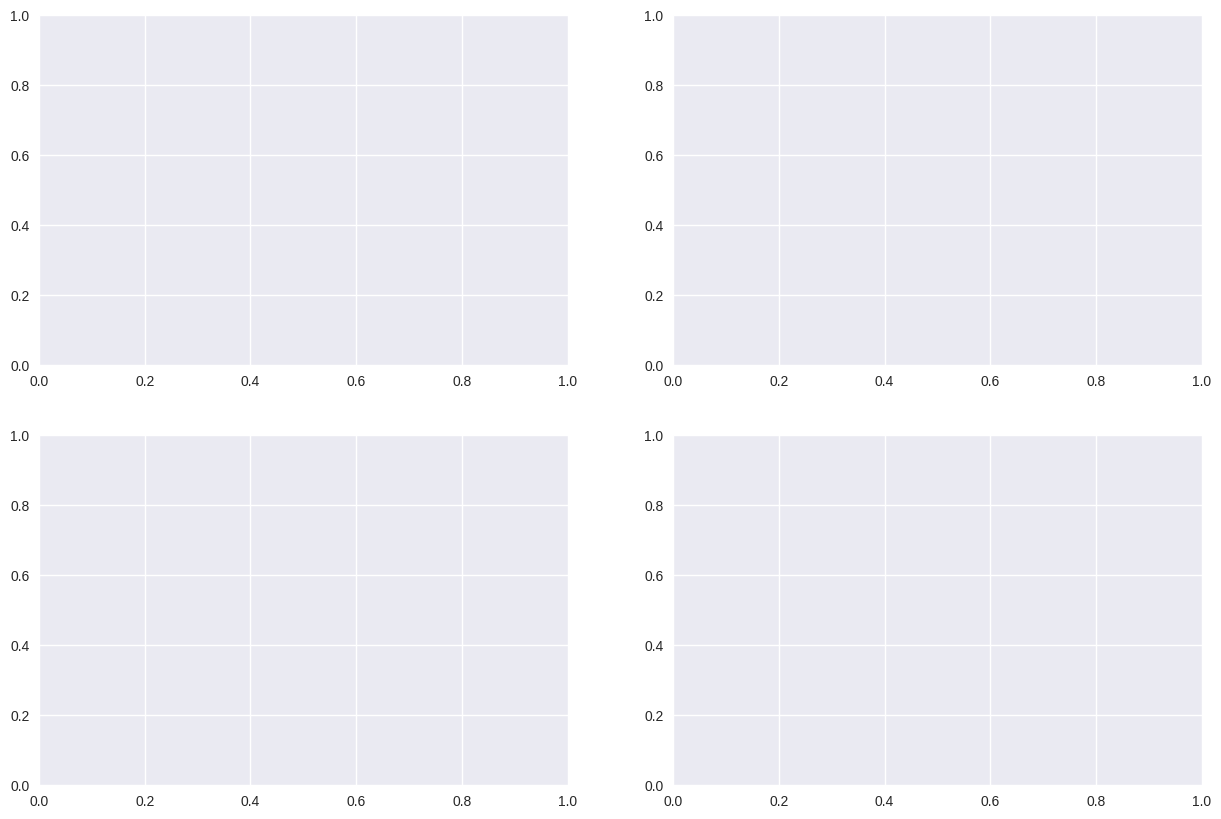

In [46]:
# now we will plot the results.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

In [47]:
for eps in epsilons:
        ax1.plot(epsilon_results[eps]['rewards'], label=f'ε = {eps}', linewidth=2)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average Reward')
ax1.set_title('Epsilon-Greedy: Average Reward over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

In [49]:
for eps in epsilons:
    optimal_data = epsilon_results[eps]['optimal']
    if len(optimal_data) < 50:
        print(f"Skipping ε = {eps} due to insufficient data ({len(optimal_data)} points).")
        continue

    optimal_pct = np.convolve(optimal_data, np.ones(50)/50, mode='valid') * 100
    ax2.plot(range(49, len(optimal_data)), optimal_pct, 
             label=f'ε = {eps}', linewidth=2)

ax2.set_xlabel('Steps')
ax2.set_ylabel('Optimal Action %')
ax2.set_title('Epsilon-Greedy: % Optimal Action (50-step moving average)')
ax2.legend()
ax2.grid(True, alpha=0.3)

Skipping ε = 0.0 due to insufficient data (0 points).
Skipping ε = 0.01 due to insufficient data (0 points).
Skipping ε = 0.1 due to insufficient data (0 points).
Skipping ε = 0.3 due to insufficient data (0 points).


In [52]:
for c in c_values:
    if c not in ucb_results:
        print(f"Skipping c = {c}: not found in ucb_results.")
        continue
    if 'optimal' not in ucb_results[c]:
        print(f"Skipping c = {c}: 'optimal' key missing in ucb_results.")
        continue
    if len(ucb_results[c]['optimal']) < 50:
        print(f"Skipping c = {c}: not enough data for moving average (found {len(ucb_results[c]['optimal'])} steps).")
        continue

    optimal_pct = np.convolve(ucb_results[c]['optimal'], np.ones(50)/50, mode='valid') * 100
    ax4.plot(range(49, len(ucb_results[c]['optimal'])), optimal_pct, 
             label=f'c = {c}', linewidth=2)

Skipping c = 0.5: 'optimal' key missing in ucb_results.
Skipping c = 1.0: 'optimal' key missing in ucb_results.
Skipping c = 2.0: 'optimal' key missing in ucb_results.
Skipping c = 4.0: 'optimal' key missing in ucb_results.


In [53]:
ax4.set_xlabel('Steps')
ax4.set_ylabel('Optimal Action %')
ax4.set_title('UCB: % Optimal Action (50-step moving average)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

## Comparing the best epsilon-greedy vs best UCB

In [56]:
print("\n" + "="*50)
print("COMPARISON SUMMARY")
print("="*50)

best_eps = max(epsilons, key=lambda x: epsilon_results[x]['rewards'][-100:].mean())
best_c = max(c_values, key=lambda x: ucb_results[x]['rewards'][-100:].mean())

print(f"Best Epsilon-Greedy (ε={best_eps}):")
print(f"  Final 100 steps avg reward: {epsilon_results[best_eps]['rewards'][-100:].mean():.3f}")
print(f"  Final 100 steps optimal %: {epsilon_results[best_eps]['optimal'][-100:].mean()*100:.1f}%")

print(f"\nBest UCB (c={best_c}):")
print(f"  Final 100 steps avg reward: {ucb_results[best_c]['rewards'][-100:].mean():.3f}")

if 'optimal' in ucb_results[best_c]:
    print(f"  Final 100 steps optimal %: {ucb_results[best_c]['optimal'][-100:].mean()*100:.1f}%")
else:
    print("  Final 100 steps optimal %: N/A (missing 'optimal' data)")

# Demonstrate the exploration-exploitation tradeoff
print("\n" + "="*50)
print("EXPLORATION-EXPLOITATION TRADEOFF ANALYSIS")
print("="*50)

# Create a single bandit for demonstration
demo_bandit = MultiArmedBandit(k=10)
print(f"True reward values: {demo_bandit.true_rewards}")
print(f"Optimal arm: {demo_bandit.optimal_arm} (reward: {demo_bandit.true_rewards[demo_bandit.optimal_arm]:.3f})")

# Show how different strategies behave
strategies = [
    ("Pure Exploitation (ε=0)", EpsilonGreedyAgent(10, 0.0, 5.0)),  # Optimistic initial values
    ("Balanced (ε=0.1)", EpsilonGreedyAgent(10, 0.1)),
    ("High Exploration (ε=0.3)", EpsilonGreedyAgent(10, 0.3)),
    ("UCB (c=2)", UCBAgent(10, 2.0))
]

print("\nAfter 200 steps:")
for name, agent in strategies:
    rewards, actions = run_experiment(demo_bandit, agent, 200)
    final_reward = np.mean(rewards[-50:])  # Average of last 50 steps
    optimal_pct = sum(1 for a in actions[-50:] if a == demo_bandit.optimal_arm) / 50 * 100
    print(f"{name:25} | Avg Reward: {final_reward:.3f} | Optimal Actions: {optimal_pct:4.1f}%")


COMPARISON SUMMARY
Best Epsilon-Greedy (ε=0.1):
  Final 100 steps avg reward: 2.888
  Final 100 steps optimal %: nan%

Best UCB (c=1.0):
  Final 100 steps avg reward: 3.084
  Final 100 steps optimal %: N/A (missing 'optimal' data)

EXPLORATION-EXPLOITATION TRADEOFF ANALYSIS
True reward values: [-1.14955911  0.61549265  0.2489331  -0.52883284 -1.30382631  1.86396855
 -0.52878304  0.36426436  0.17206852 -1.68501161]
Optimal arm: 5 (reward: 1.864)

After 200 steps:
Pure Exploitation (ε=0)   | Avg Reward: 3.613 | Optimal Actions:  0.0%
Balanced (ε=0.1)          | Avg Reward: 3.384 | Optimal Actions:  0.0%
High Exploration (ε=0.3)  | Avg Reward: 2.776 | Optimal Actions:  0.0%
UCB (c=2)                 | Avg Reward: 3.241 | Optimal Actions:  0.0%


/tmp/ipykernel_36/466793342.py:10: RuntimeWarning: Mean of empty slice.
  print(f"  Final 100 steps optimal %: {epsilon_results[best_eps]['optimal'][-100:].mean()*100:.1f}%")
